In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pr_ds = xr.open_dataset('/work/users/jn906hluu/Climate/Precipitation/pr_hyras_1_2022_v5-0_de.nc')

lon_min, lat_min, lon_max, lat_max = [10.294189,50.307024,11.961365,50.972242]

## The Problem: 

The grids are not rectangular in lat, lon as the earth is round and not flat. This is bad for us though, as we need the same "projection" of all our data to compare them. As I choose kind of a "flat earth" projection for the S2 data, we'll do the same here... 

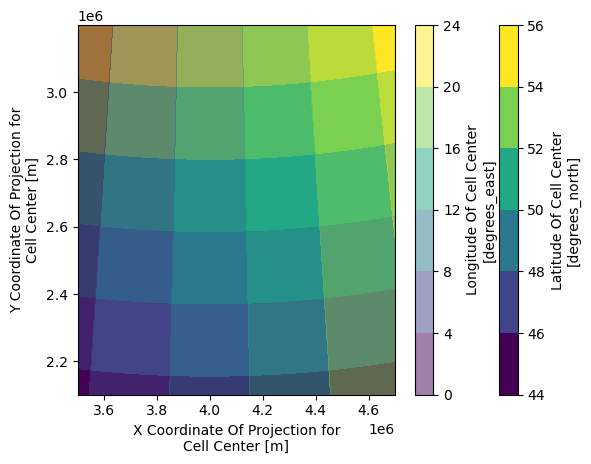

In [45]:
pr_ds.lat.plot.contourf()
pr_ds.lon.plot.contourf(alpha=0.5)

First make a box in which all the relevant data is masked. Lats and Lons which are inside the bounding box will be masked True. Then apply this mask with `.where()` to the Precipitation dataset and drop the NaNs (as `.where()` would return as the full shape of the object, but we're just interested in our region). Notice the option of `.dropna(dim=..., how='all)` where `how='all` only selects the rows/cols where ALL values are NaN.  

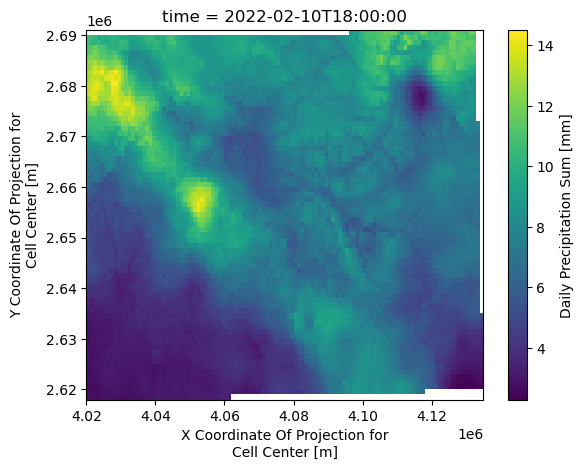

In [46]:
region_box = (pr_ds.lon < lon_max) & (pr_ds.lon > lon_min) & (pr_ds.lat < lat_max) & (pr_ds.lat > lat_min)
pr_sel = pr_ds.pr.isel(time=40).where(region_box).dropna(dim='x', how='all').dropna(dim='y', how='all')
pr_sel.plot()


## Creating the new dataset

From here on it's kind of straight forward. Make an array where we mask all the precipitaion data accordingly to `region_box`, get the shapes of our dimensions and look for the lats & lons at the edges. Then make a new xarray Dataset with the data and that's it! 

In [47]:
pr_no_nan = np.array([pr_ds.pr.isel(time=i).where(region_box).dropna(dim='x', how='all').dropna(dim='y', how='all').values for i in range(365)])
dim_time, dim_y, dim_x = pr_no_nan.shape
pr_lat_max, pr_lat_min, pr_lon_min, pr_lon_max = pr_sel.lat[-1,0].values, pr_sel.lat[0,0].values, pr_sel.lon[-1,0].values, pr_sel.lon[0,-1].values

In [48]:
pr_reproject = xr.Dataset(
    data_vars= dict(
        pr = (['time', 'lat', 'lon'], pr_no_nan),
    ),
    coords= dict(
        time = pr_ds.time.values,
        lat = np.linspace(pr_lat_max, pr_lat_min, dim_y),
        lon = np.linspace(pr_lon_min, pr_lon_max, dim_x)
    )
)
pr_reproject

<xarray.Dataset>
Dimensions:  (time: 365, lat: 73, lon: 115)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01T18:00:00 ... 2022-12-31T18:00:00
  * lat      (lat) float64 50.98 50.97 50.96 50.95 ... 50.34 50.33 50.32 50.31
  * lon      (lon) float64 10.3 10.32 10.33 10.35 ... 11.91 11.93 11.94 11.95
Data variables:
    pr       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 nan nan

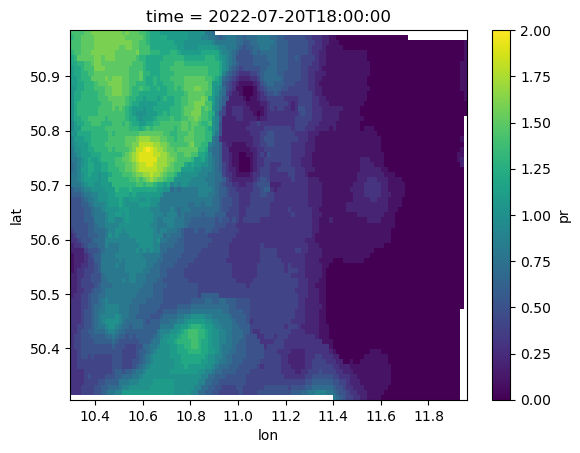

In [49]:
pr_reproject.isel(time=200).pr.plot()

TODO: 

- make a folder at SC-Cluster and download precipitation and temperature raw_data from the DWD HYRAS model at ```https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/``` wit hthe `wget` command. 
- convert them with the above procedure and save them as `.zarr` somewhere. 
- For soil moisture this could be a little bit trickier, as these are .ascii files. Though the conversion shouldn't be too hard as they are in Easting/Northing. There should be rasterio function or something to convert them to WGS84. For more information, see `https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/soil_moist/The_1km_file_of_DWD.pdf` 